In [1]:
import json
import unidecode
import contractions
from nltk import sent_tokenize, word_tokenize
import nltk
import logging
import re
import string
import spacy
from sklearn.metrics import confusion_matrix
from seqeval.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score
from seqeval.scheme import IOB2

import matplotlib.pyplot as plt
# import numpy as np

logger = logging.getLogger(__name__)
stop_words = nltk.corpus.stopwords.words('english')
#deselect 'no' and 'not' from stop words
stop_words.remove('no')
stop_words.remove('not')

## Do not remove '.' ',' ';' ':'
english_punctuations = ['``','?', '（','）','(', ')',
                '[', ']', '&', '!', '*', '@', '#', '$', '%','\\','\"','}','{','=','/','>','<','|','+','_','~']
english_punctuations_arr= ''.join(english_punctuations)

In [2]:
def read_json_array(path):
    '''Read JSON given array of dictionaries'''
    with open(path, "r", encoding="utf-8") as fp:
        datas = json.loads(fp.read())
    return datas

trainData = read_json_array("../data/pubmed_data/json_data_synthetic_labels/v2_train.json")
testData = read_json_array("../data/pubmed_data/json_data_synthetic_labels/v2_test.json")
gs42Data = read_json_array("../data/pubmed_data/json_data_synthetic_labels/v2_testgs42.json")
gs91Data = read_json_array("../data/pubmed_data/json_data_synthetic_labels/v2_testgs91.json")
gsCombData = gs42Data+gs91Data

In [3]:
def sent2words(sent):
    '''Pre-process sentence text to words'''
    
    ## Expand Words
    sent = contractions.fix(sent)
    
    ## Convert sentence to lowercase and strip whitespaces
    sent = sent.lower().strip()
    
    ## Convert unicode characters in sentence to ASCII
    sent = unidecode.unidecode(sent)
    sent = sent.encode("ascii", "ignore").decode()
    
    ## Remove URL's from Sentence
    sent = re.sub('http[s]?://\S+', '', sent)
    
    ## Remove words like 2.0-2
    sent = re.sub(' \d*\.*\d*\-+\d*\.*\d* ', ' ', sent)
    
    # Remove punctuation characters
    sent = sent.translate(str.maketrans(english_punctuations_arr,' '*len(english_punctuations_arr)))
    
    pos, length = {}, {}
    words = word_tokenize(sent)
    for i, (w, p) in enumerate(nltk.pos_tag(words)):
        # Computational features
        pos[w] = p
        length[w] = len(w)
    
    # Remove Stop Words
    # words = [word for word in word_tokenize(sent) if not word in stop_words]
    
    # Remove punctuation only strings from sentence
    words = [word for word in words if not all(c in string.punctuation for c in word) and len(word)>1]
    
    # Remove Numericals from sentence
    words = [x for x in words if not all(c.isdigit() for c in x)] 
    
    ## Return words, POS tags, lengths of words, processed sentence
    return words, pos, length, ' '.join(words)

# Mark Keyphrases with BIO Format Labels
def mark_keyword_all_sentences(keywords, sentences):

    sentence_lengths = [len(sent) for sent in sentences]
    logger.debug("Sentence length: %s"%sentence_lengths)

    complete_text = []
    for sent in sentences:
        complete_text.extend(sent)
    logger.debug("Complete Text: %s"%complete_text)

    complete_text_len = len(complete_text)
    mapper = ['O']*complete_text_len
    kws = [sent2words(x)[0] for x in keywords]

    for kw in kws:
        kw_len=len(kw)
        if kw_len == 0:
            continue
        i=0
        while i<complete_text_len-kw_len:
            if complete_text[i:i+kw_len]==kw and mapper[i:i+kw_len]==['O']*kw_len:
                mapper[i:i+kw_len]=['I-KP']*kw_len
                mapper[i]='B-KP'
            i+=1

    final_mapper = []
    final_tokens = []
    start=0

    for slen in sentence_lengths:
        final_mapper.append(mapper[start:start+slen])
        final_tokens.append(complete_text[start:start+slen])
        start+=slen
    
    return complete_text, final_mapper, final_tokens

In [9]:
def createBERTtSV(data,filename):
    # import csv
    # trainCSV = "../data/trainBERT.tsv"
    f = open(filename,'w')
    f.close()

    for article in data:
        textData = []
        for sent in sent_tokenize(article['title']+' '+article['abstract']):
            words, _, _, _ = sent2words(sent)
            # words.append('.')
            textData.append(words)
        # textData = [word_tokenize(sent) for sent in sent_tokenize(article['title']+' '+article['abstract'])]
        #print(textData)
        _, mapper, tokens = mark_keyword_all_sentences(article['keywords'],textData)
        with open(filename,'a') as f:
        # with open(trainCSV, 'w', encoding='utf8', newline='') as tsv_file:
        #     tsv_writer = csv.writer(tsv_file, delimiter='\t', lineterminator='\n')
        #     tsv_writer.writerow(["Word", "Count"])
            print("-DOCSTART- -X- O O", file=f)
            for sentM, sentT in zip(mapper, tokens):
                for wordM, wordT in zip(sentM, sentT):
                    print("{}\t{}".format(wordT,wordM), file=f)
        # print(mapper, tokens)
        
def getTargetPreds(data, title="Default"):
    comb_arr = []
    for article in data:
        comb_arr.append(article['title']+' '+article['abstract'])

    y_preds, y_targets = [], []
    kws_len_preds, kw_len_targets = [], []
    for idx, doc in enumerate(nlp.pipe(comb_arr)):

        kws = [str(x) for x in doc.ents]
        textData = []
        for sent in sent_tokenize(article['title']+' '+article['abstract']):
            words, _, _, _ = sent2words(sent)
            textData.append(words)
        # textData = [word_tokenize(sent) for sent in sent_tokenize(data[idx]['title']+' '+data[idx]['abstract'])]

        _, target, _ = mark_keyword_all_sentences(data[idx]['keywords'],textData)
        _, predict, _ = mark_keyword_all_sentences(kws,textData)
        kw_len_targets.append(len(data[idx]['keywords']))
        kws_len_preds.append(len(kws))
        #print(gs40Data[idx]['id'],gs40Data[idx]['keywords'],kws,sep='\n')

        #print(target,predict,sep='\n')
        y_preds.extend(predict)
        y_targets.extend(target)
        
    plt.title("KPs Identified - Prediction vs. Targets : " + title)
    box_plot_data=[kws_len_preds, kw_len_targets]
    plt.boxplot(box_plot_data,patch_artist=True,labels=['Predictions','Targets'])
    plt.grid()
    plt.show()
    
    return y_preds, y_targets

In [5]:
totalData = trainData+testData
datalen = len(totalData)
print("Data: {}, Train: {} Val: {} Test: {}".format(datalen, datalen*0.6, datalen*0.2, datalen*0.2))
createBERTtSV(totalData[:int(0.6*datalen)],'../data/trainSpacy.tsv')
createBERTtSV(totalData[int(0.6*datalen):int(0.8*datalen)],'../data/validSpacy.tsv')
createBERTtSV(totalData[int(0.8*datalen):],'../data/testSpacy.tsv')

createBERTtSV(gs42Data,'../data/gs42SpacyFull.tsv')
gs_datalen = len(gs42Data)
print("GS42 Data: {}, GS42 Train: {} GS42 Val: {}".format(gs_datalen, gs_datalen*0.8, gs_datalen*0.2))
createBERTtSV(gs42Data[:int(0.8*gs_datalen)],'../data/gs42Spacy_T.tsv')
createBERTtSV(gs42Data[int(0.8*gs_datalen):],'../data/gs42Spacy_V.tsv')

createBERTtSV(gs91Data,'../data/gs91SpacyFull.tsv')
gs_datalen = len(gs91Data)
print("GS91 Data: {}, GS91 Train: {} GS91 Val: {}".format(gs_datalen, gs_datalen*0.8, gs_datalen*0.2))
createBERTtSV(gs91Data[:int(0.8*gs_datalen)],'../data/gs91Spacy_T.tsv')
createBERTtSV(gs91Data[int(0.8*gs_datalen):],'../data/gs91Spacy_V.tsv')

Data: 3110, Train: 1866.0 Val: 622.0 Test: 622.0
GS42 Data: 42, GS42 Train: 33.6 GS42 Val: 8.4
GS91 Data: 91, GS91 Train: 72.8 GS91 Val: 18.2


In [6]:
import sys
!cd ../data && {sys.executable} -m spacy convert trainSpacy.tsv ./ -t json -n 1 -c iob
!cd ../data && {sys.executable} -m spacy convert validSpacy.tsv ./ -t json -n 1 -c iob
!cd ../data && {sys.executable} -m spacy convert testSpacy.tsv ./ -t json -n 1 -c iob
!cd ../data && {sys.executable} -m spacy convert gs42SpacyFull.tsv ./ -t json -n 1 -c iob
!cd ../data && {sys.executable} -m spacy convert gs42Spacy_T.tsv ./ -t json -n 1 -c iob
!cd ../data && {sys.executable} -m spacy convert gs42Spacy_V.tsv ./ -t json -n 1 -c iob
!cd ../data && {sys.executable} -m spacy convert gs91SpacyFull.tsv ./ -t json -n 1 -c iob
!cd ../data && {sys.executable} -m spacy convert gs91Spacy_T.tsv ./ -t json -n 1 -c iob
!cd ../data && {sys.executable} -m spacy convert gs91Spacy_V.tsv ./ -t json -n 1 -c iob

ℹ Auto-detected token-per-line NER format
⚠ Document delimiters found, automatic document segmentation with `-n`
disabled.
⚠ No sentence boundaries found. Use `-s` to automatically segment
sentences.
✔ Generated output file (1 documents): trainSpacy.json
ℹ Auto-detected token-per-line NER format
⚠ Document delimiters found, automatic document segmentation with `-n`
disabled.
⚠ No sentence boundaries found. Use `-s` to automatically segment
sentences.
✔ Generated output file (1 documents): validSpacy.json
ℹ Auto-detected token-per-line NER format
⚠ Document delimiters found, automatic document segmentation with `-n`
disabled.
⚠ No sentence boundaries found. Use `-s` to automatically segment
sentences.
✔ Generated output file (1 documents): testSpacy.json
ℹ Auto-detected token-per-line NER format
⚠ Document delimiters found, automatic document segmentation with `-n`
disabled.
⚠ No sentence boundaries found. Use `-s` to automatically segment
sentences.
✔ Generated output file (1 documents

In [7]:
!cd ../data && {sys.executable} -m spacy convert trainSpacy.json ./ -t spacy
!cd ../data && {sys.executable} -m spacy convert validSpacy.json ./ -t spacy
!cd ../data && {sys.executable} -m spacy convert testSpacy.json ./ -t spacy
!cd ../data && {sys.executable} -m spacy convert gs42SpacyFull.json ./ -t spacy
!cd ../data && {sys.executable} -m spacy convert gs42Spacy_T.json ./ -t spacy
!cd ../data && {sys.executable} -m spacy convert gs42Spacy_V.json ./ -t spacy
!cd ../data && {sys.executable} -m spacy convert gs91SpacyFull.json ./ -t spacy
!cd ../data && {sys.executable} -m spacy convert gs91Spacy_T.json ./ -t spacy
!cd ../data && {sys.executable} -m spacy convert gs91Spacy_V.json ./ -t spacy

✔ Generated output file (1866 documents): trainSpacy.spacy
✔ Generated output file (622 documents): validSpacy.spacy
✔ Generated output file (622 documents): testSpacy.spacy
✔ Generated output file (42 documents): gs42SpacyFull.spacy
✔ Generated output file (33 documents): gs42Spacy_T.spacy
✔ Generated output file (9 documents): gs42Spacy_V.spacy
✔ Generated output file (91 documents): gs91SpacyFull.spacy
✔ Generated output file (72 documents): gs91Spacy_T.spacy
✔ Generated output file (19 documents): gs91Spacy_V.spacy


### Round 1:
#### Stage 1: Fine-Tune Bio-Medical sciSpacy to CDSS Domain [Common to BOTH Experiments]
sciSpacy >> Train/Val Synthetic DS >> cdssSciSpacy << Test Synthetic DS
#### Stage 2: Fine-Tune Synthetic-CDSS-sciSpacy to GS-CDSS-sciSpacy
cdssSciSpacy >> Train/Val GS42 DS >> cdssSciSpacyGS << Test G291 DS

In [8]:
## ROUND1:::STAGE1
BASE_SCISPACY_CONFIG = '''
# This is an auto-generated partial config. To use it with 'spacy train'
# you can run spacy init fill-config to auto-fill all default settings:
# python -m spacy init fill-config ./base_config.cfg ./config.cfg
[paths]
train = null
dev = null
vectors = null
[system]
gpu_allocator = "pytorch"

[nlp]
lang = "en"
pipeline = ["transformer","ner"]
batch_size = 128

[components]

[components.transformer]
factory = "transformer"

[components.transformer.model]
@architectures = "spacy-transformers.TransformerModel.v3"
name = "roberta-base"
#name = "allenai/scibert_scivocab_cased"
tokenizer_config = {"use_fast": true}

[components.transformer.model.get_spans]
@span_getters = "spacy-transformers.strided_spans.v1"
window = 128
stride = 96

[components.ner]
source = "en_core_sci_lg"

[components.ner.model]
@architectures = "spacy.TransitionBasedParser.v2"
state_type = "ner"
extra_state_tokens = false
hidden_width = 64
maxout_pieces = 2
use_upper = false
nO = null

[components.ner.model.tok2vec]
@architectures = "spacy-transformers.TransformerListener.v1"
grad_factor = 1.0

[components.ner.model.tok2vec.pooling]
@layers = "reduce_mean.v1"

[corpora]

[corpora.train]
@readers = "spacy.Corpus.v1"
path = ${paths.train}
max_length = 0

[corpora.dev]
@readers = "spacy.Corpus.v1"
path = ${paths.dev}
max_length = 0

[training]
accumulate_gradient = 3
dev_corpus = "corpora.dev"
train_corpus = "corpora.train"

[training.optimizer]
@optimizers = "Adam.v1"

[training.optimizer.learn_rate]
@schedules = "warmup_linear.v1"
warmup_steps = 250
total_steps = 20000
initial_rate = 5e-5

[training.batcher]
@batchers = "spacy.batch_by_padded.v1"
discard_oversize = true
size = 2000
buffer = 256

[initialize]
vectors = ${paths.vectors}

[initialize.before_init]
@callbacks: "spacy.copy_from_base_model.v1"
tokenizer: "en_core_sci_lg"
vocab: "en_core_sci_lg"
'''
with open('tempSpacy.cfg','w') as f:
    f.write(BASE_SCISPACY_CONFIG)

!{sys.executable} -m spacy init fill-config tempSpacy.cfg config.cfg

/home/rgoli/.conda/envs/pytorch/lib/python3.8/site-packages/spacy/util.py:833: UserWarning: [W095] Model 'en_core_sci_lg' (0.4.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.2.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [9]:
!{sys.executable} -m spacy train -g 0 config.cfg --output ../cdssSciSpacy --paths.train ../data/trainSpacy.spacy --paths.dev ../data/validSpacy.spacy 

ℹ Saving to output directory: ../cdssSciSpacy
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
/home/rgoli/.conda/envs/pytorch/lib/python3.8/site-packages/spacy/util.py:833: UserWarning: [W095] Model 'en_core_sci_lg' (0.4.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.2.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
[2022-09-03 15:35:32,318] [INFO] Set up nlp object from config
[2022-09-03 15:35:32,327] [INFO] Pipeline: ['transformer', 'ner']
[2022-09-03 15:35:32,327] [INFO] Resuming training for: ['ner']
[2022-09-03 15:35:32,334] [INFO] Copying tokenizer from: en_core_sci_lg
/home/rgoli/.conda/envs/pytorch/lib/python3.8/site-packages/spacy/util.py:833: UserWarning: [W095] Model 'en_core_sci_lg' (0.4.0) was trai

In [5]:
def printMetrics(y_targets, y_preds,custom=''):
    print("\nSeqEval Metrics on sciSpacy {}:\n".format(custom))
    print(classification_report(y_targets, y_preds, mode='strict', scheme=IOB2))
    print("Precision given by SeqEval: {:.2f}%".format(precision_score(y_targets, y_preds)*100))
    print("Recall given by SeqEval: {:.2f}%".format(recall_score(y_targets, y_preds)*100))
    print("F1-Score given by SeqEval: {:.2f}%".format(f1_score(y_targets, y_preds)*100))
    print("Accuracy given by SeqEval: {:.2f}%".format(accuracy_score(y_targets, y_preds)*100))
    print("-"*60)

/home/rgoli/.conda/envs/pytorch/lib/python3.8/site-packages/spacy/util.py:833: UserWarning: [W095] Model 'en_core_sci_lg' (0.4.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.2.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


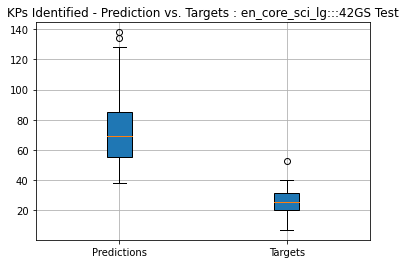


SeqEval Metrics on sciSpacy + 42GS Test:

              precision    recall  f1-score   support

          KP       0.61      0.17      0.27       675

   micro avg       0.61      0.17      0.27       675
   macro avg       0.61      0.17      0.27       675
weighted avg       0.61      0.17      0.27       675

Precision given by SeqEval: 60.82%
Recall given by SeqEval: 17.48%
F1-Score given by SeqEval: 27.16%
Accuracy given by SeqEval: 93.18%
------------------------------------------------------------


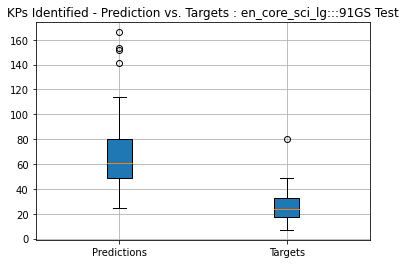


SeqEval Metrics on sciSpacy + 91GS Test:

              precision    recall  f1-score   support

          KP       0.59      0.23      0.33       900

   micro avg       0.59      0.23      0.33       900
   macro avg       0.59      0.23      0.33       900
weighted avg       0.59      0.23      0.33       900

Precision given by SeqEval: 58.79%
Recall given by SeqEval: 22.67%
F1-Score given by SeqEval: 32.72%
Accuracy given by SeqEval: 96.49%
------------------------------------------------------------


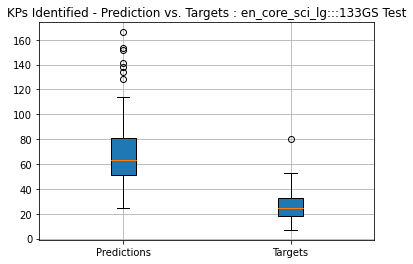


SeqEval Metrics on sciSpacy + 133GS Test:

              precision    recall  f1-score   support

          KP       0.62      0.22      0.33      1483

   micro avg       0.62      0.22      0.33      1483
   macro avg       0.62      0.22      0.33      1483
weighted avg       0.62      0.22      0.33      1483

Precision given by SeqEval: 61.82%
Recall given by SeqEval: 22.39%
F1-Score given by SeqEval: 32.87%
Accuracy given by SeqEval: 96.08%
------------------------------------------------------------


In [10]:
nlp = spacy.load('en_core_sci_lg')

y_preds, y_targets = getTargetPreds(gs42Data, 'en_core_sci_lg:::42GS Test')
printMetrics(y_preds, y_targets, '+ 42GS Test')

y_preds, y_targets = getTargetPreds(gs91Data, 'en_core_sci_lg:::91GS Test')
printMetrics(y_preds, y_targets, '+ 91GS Test')

y_preds, y_targets = getTargetPreds(gsCombData, 'en_core_sci_lg:::133GS Test')
printMetrics(y_preds, y_targets, '+ 133GS Test')

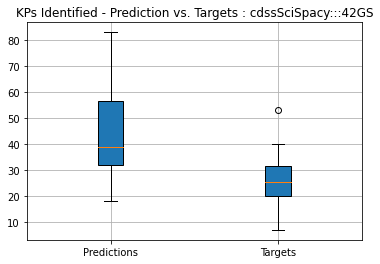


SeqEval Metrics on sciSpacy + Synthetic 1866 Train / 622 Val + 42GS Test:

              precision    recall  f1-score   support

          KP       0.70      0.38      0.50       355

   micro avg       0.70      0.38      0.50       355
   macro avg       0.70      0.38      0.50       355
weighted avg       0.70      0.38      0.50       355

Precision given by SeqEval: 70.10%
Recall given by SeqEval: 38.31%
F1-Score given by SeqEval: 49.54%
Accuracy given by SeqEval: 96.73%
------------------------------------------------------------


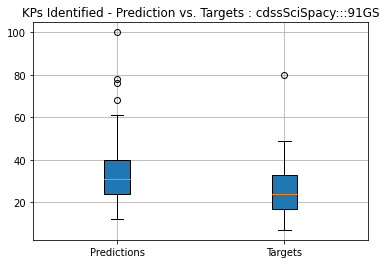


SeqEval Metrics on sciSpacy + Synthetic 1866 Train / 622 Val + 91GS Test:

              precision    recall  f1-score   support

          KP       0.73      0.64      0.68       393

   micro avg       0.73      0.64      0.68       393
   macro avg       0.73      0.64      0.68       393
weighted avg       0.73      0.64      0.68       393

Precision given by SeqEval: 72.62%
Recall given by SeqEval: 64.12%
F1-Score given by SeqEval: 68.11%
Accuracy given by SeqEval: 98.88%
------------------------------------------------------------


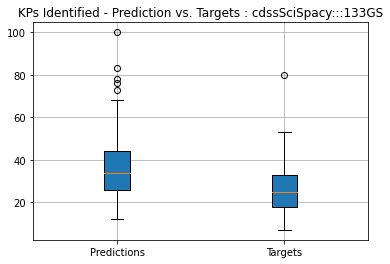


SeqEval Metrics on sciSpacy + Synthetic 1866 Train / 622 Val + 133GS Test:

              precision    recall  f1-score   support

          KP       0.74      0.59      0.66       672

   micro avg       0.74      0.59      0.66       672
   macro avg       0.74      0.59      0.66       672
weighted avg       0.74      0.59      0.66       672

Precision given by SeqEval: 73.93%
Recall given by SeqEval: 59.08%
F1-Score given by SeqEval: 65.67%
Accuracy given by SeqEval: 98.66%
------------------------------------------------------------


In [11]:
nlp = spacy.load('../cdssSciSpacy/model-best')

y_preds, y_targets = getTargetPreds(gs42Data, 'cdssSciSpacy:::42GS')
printMetrics(y_preds, y_targets, '+ Synthetic 1866 Train / 622 Val + 42GS Test')

y_preds, y_targets = getTargetPreds(gs91Data, 'cdssSciSpacy:::91GS')
printMetrics(y_preds, y_targets, '+ Synthetic 1866 Train / 622 Val + 91GS Test')

y_preds, y_targets = getTargetPreds(gsCombData, 'cdssSciSpacy:::133GS')
printMetrics(y_preds, y_targets, '+ Synthetic 1866 Train / 622 Val + 133GS Test')

In [27]:
## ROUND1 ::: STAGE2
BASE_SCISPACY_42GS_CONFIG = '''
# This is an auto-generated partial config. To use it with 'spacy train'
# you can run spacy init fill-config to auto-fill all default settings:
# python -m spacy init fill-config ./base_config.cfg ./config.cfg
[paths]
train = null
dev = null
vectors = null
[system]
gpu_allocator = "pytorch"

[nlp]
lang = "en"
pipeline = ["transformer","ner"]
batch_size = 128

[components]

[components.transformer]
factory = "transformer"

[components.transformer.model]
@architectures = "spacy-transformers.TransformerModel.v3"
name = "roberta-base"
#name = "allenai/scibert_scivocab_cased"
tokenizer_config = {"use_fast": true}

[components.transformer.model.get_spans]
@span_getters = "spacy-transformers.strided_spans.v1"
window = 128
stride = 96

[components.ner]
source = "../cdssSciSpacy/model-best"

[components.ner.model]
@architectures = "spacy.TransitionBasedParser.v2"
state_type = "ner"
extra_state_tokens = false
hidden_width = 64
maxout_pieces = 2
use_upper = false
nO = null

[components.ner.model.tok2vec]
@architectures = "spacy-transformers.TransformerListener.v1"
grad_factor = 1.0

[components.ner.model.tok2vec.pooling]
@layers = "reduce_mean.v1"

[corpora]

[corpora.train]
@readers = "spacy.Corpus.v1"
path = ${paths.train}
max_length = 0

[corpora.dev]
@readers = "spacy.Corpus.v1"
path = ${paths.dev}
max_length = 0

[training]
accumulate_gradient = 3
dev_corpus = "corpora.dev"
train_corpus = "corpora.train"

[training.optimizer]
@optimizers = "Adam.v1"

[training.optimizer.learn_rate]
@schedules = "warmup_linear.v1"
warmup_steps = 250
total_steps = 20000
initial_rate = 5e-5

[training.batcher]
@batchers = "spacy.batch_by_padded.v1"
discard_oversize = true
size = 2000
buffer = 256

[initialize]
vectors = ${paths.vectors}

[initialize.before_init]
@callbacks: "spacy.copy_from_base_model.v1"
tokenizer: "../cdssSciSpacy/model-best"
vocab: "../cdssSciSpacy/model-best"
'''
with open('tempSpacy42GS.cfg','w') as f:
    f.write(BASE_SCISPACY_42GS_CONFIG)

!{sys.executable} -m spacy init fill-config tempSpacy42GS.cfg config.cfg

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [28]:
## ROUND1 ::: STAGE2
!{sys.executable} -m spacy train -g 0 config.cfg --output ../cdssSciSpacyGS42 --paths.train ../data/gs42Spacy_T.spacy --paths.dev ../data/gs42Spacy_V.spacy 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
✔ Created output directory: ../cdssSciSpacyGS42
ℹ Saving to output directory: ../cdssSciSpacyGS42
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2022-09-03 17:52:06,974] [INFO] Set up nlp object from config
[2022-09-03 17:52:06,986] [INFO] Pipeline: ['transformer', 'ner']
[2022-09-03 17:52:06,986] [INFO] Resuming training for: ['ner']
[2022-09-03 17:52:06,996] [INFO] Copying tokenizer from: ../cdssSciSpacy/model-best
[2022-09-03 17:52:14,344] [INFO] Copying vocab from: ../cdssSciSpacy/model-best
[2022-09-03 17:52:28,586] [INFO] Created vocabulary
[2022-09-03 17:52:30,328] [INFO] Finished initializing nlp object
Some weig

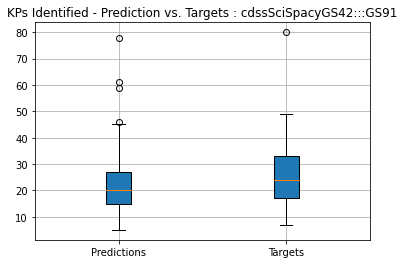


SeqEval Metrics on sciSpacy + Synthetic 1866 Train / 622 Val + 42GS 33 Train / 9 Val + 91GS Test:

              precision    recall  f1-score   support

          KP       0.57      0.64      0.60       310

   micro avg       0.57      0.64      0.60       310
   macro avg       0.57      0.64      0.60       310
weighted avg       0.57      0.64      0.60       310

Precision given by SeqEval: 57.06%
Recall given by SeqEval: 63.87%
F1-Score given by SeqEval: 60.27%
Accuracy given by SeqEval: 98.79%
------------------------------------------------------------


In [12]:
nlp = spacy.load('../cdssSciSpacyGS42/model-best')

y_preds, y_targets = getTargetPreds(gs91Data, 'cdssSciSpacyGS42:::GS91')
printMetrics(y_preds, y_targets, '+ Synthetic 1866 Train / 622 Val + 42GS 33 Train / 9 Val + 91GS Test')

### Round 2:
#### Stage 1: Fine-Tune Bio-Medical sciSpacy to CDSS Domain [Common to BOTH Experiments]
sciSpacy >> Train/Val Synthetic DS >> cdssSciSpacy << Test Synthetic DS
#### Stage 2: Fine-Tune Synthetic-CDSS-sciSpacy to GS-CDSS-sciSpacy
cdssSciSpacy >> Train/Val GS91 DS >> cdssSciSpacyGS << Test G242 DS

In [30]:
## ROUND2 ::: STAGE2
!{sys.executable} -m spacy train -g 0 config.cfg --output ../cdssSciSpacyGS91 --paths.train ../data/gs91Spacy_T.spacy --paths.dev ../data/gs91Spacy_V.spacy 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
✔ Created output directory: ../cdssSciSpacyGS91
ℹ Saving to output directory: ../cdssSciSpacyGS91
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2022-09-03 18:31:33,089] [INFO] Set up nlp object from config
[2022-09-03 18:31:33,103] [INFO] Pipeline: ['transformer', 'ner']
[2022-09-03 18:31:33,103] [INFO] Resuming training for: ['ner']
[2022-09-03 18:31:33,112] [INFO] Copying tokenizer from: ../cdssSciSpacy/model-best
[2022-09-03 18:31:40,590] [INFO] Copying vocab from: ../cdssSciSpacy/model-best
[2022-09-03 18:31:53,996] [INFO] Created vocabulary
[2022-09-03 18:31:55,637] [INFO] Finished initializing nlp object
Some weig

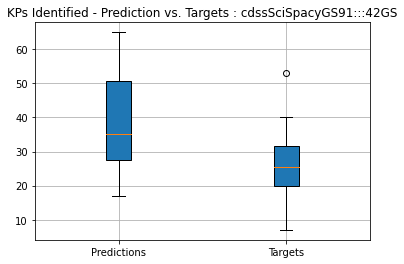


SeqEval Metrics on sciSpacy + Synthetic 1866 Train / 622 Val + 91GS 72 Train / 19 Val + 42GS Test:

              precision    recall  f1-score   support

          KP       0.66      0.38      0.48       341

   micro avg       0.66      0.38      0.48       341
   macro avg       0.66      0.38      0.48       341
weighted avg       0.66      0.38      0.48       341

Precision given by SeqEval: 65.98%
Recall given by SeqEval: 37.54%
F1-Score given by SeqEval: 47.85%
Accuracy given by SeqEval: 96.70%
------------------------------------------------------------


In [13]:
nlp = spacy.load('../cdssSciSpacyGS91/model-best')

y_preds, y_targets = getTargetPreds(gs42Data, 'cdssSciSpacyGS91:::42GS')
printMetrics(y_preds, y_targets, '+ Synthetic 1866 Train / 622 Val + 91GS 72 Train / 19 Val + 42GS Test')

### Round 3:
#### Stage 1: Fine-Tune Bio-Medical sciSpacy to CDSS Domain [Common to BOTH Experiments]
sciSpacy >> Train/Val Synthetic DS >> cdssSciSpacy << Test Synthetic DS
#### Stage 2: Experiment 50 Times ::: Fine-Tune Synthetic-CDSS-sciSpacy to Random Sample GS133 - 52 Train / 14 Validate / 67 Test
cdssSciSpacy >> Train/Val GS66 DS >> cdssSciSpacyGS << Test GS67 DS

In [1]:
import pandas as pd

df = pd.read_csv('../results/cdssSpacyExp/cdssSpacyExp_results.csv', sep=';')

df.describe()

,No.,Precision,Recall,F1Score,Accuracy
count,50.00000,50.000000,50.000000,50.000000,50.000000
mean,25.50000,63.354669,61.767123,62.173416,98.668695
std,14.57738,7.703414,9.473819,7.414468,0.588110
min,1.00000,47.783251,37.658228,46.491228,96.777793
25%,13.25000,57.766272,58.383865,58.303158,98.412014
50%,25.50000,64.065671,62.913147,62.781920,98.764402
75%,37.75000,69.629364,68.457557,68.022469,99.099252
max,50.00000,79.338843,77.358491,75.889328,99.668325


<AxesSubplot:>

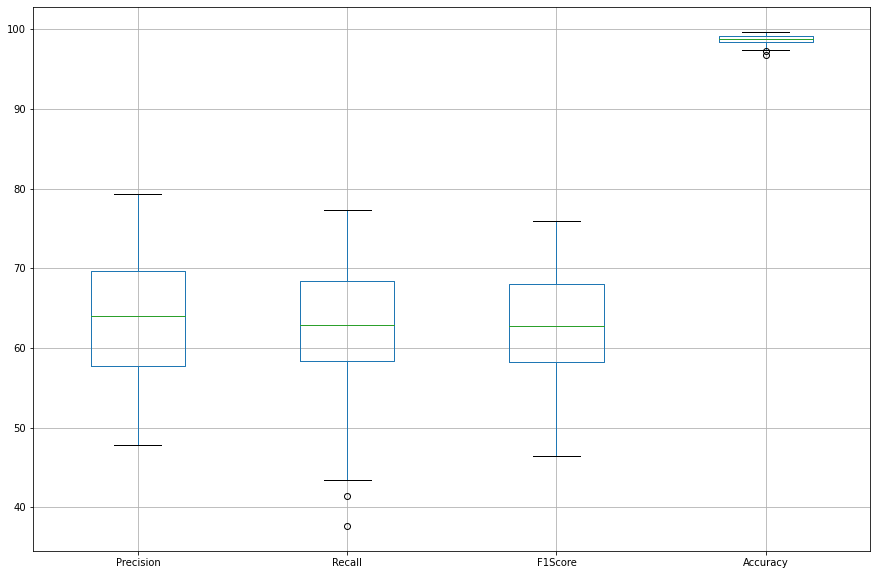

In [2]:
df.boxplot(column=['Precision', 'Recall', 'F1Score','Accuracy'],figsize=(15, 10))  

In [4]:
df = pd.read_csv('../results/cdssSpacyExp/sciSpacyExp42GS_results.csv', sep=';')
df.describe()

,No.,Precision,Recall,F1Score,Accuracy
count,50.00000,50.000000,50.000000,50.000000,50.000000
mean,25.50000,57.388151,54.262225,55.390315,98.557063
std,14.57738,9.037766,9.737854,8.221835,0.532450
min,1.00000,31.355932,38.914027,38.743455,97.342033
25%,13.25000,52.606650,47.501840,49.899111,98.216359
50%,25.50000,58.607162,53.328411,56.575097,98.672409
75%,37.75000,63.257803,60.468762,61.396326,98.892162
max,50.00000,73.109244,75.434243,72.640382,99.479468


<AxesSubplot:>

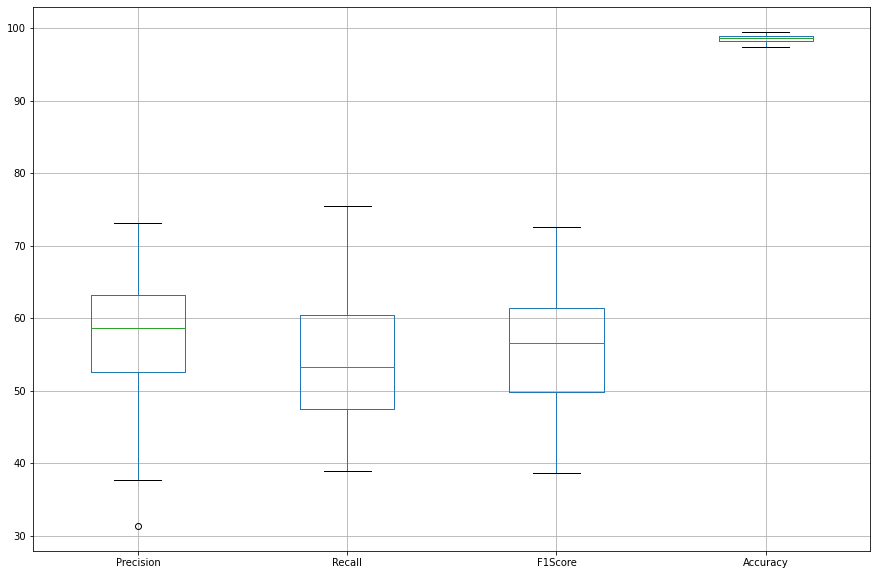

In [5]:
df.boxplot(column=['Precision', 'Recall', 'F1Score','Accuracy'],figsize=(15, 10))  